# Our implementation of ALNS for the TOPTW-problem

## Read the file and create the nessecairy instances
This is all from the original notebook.

Use the first cell to set the parameters so the paths link up. This maybe needs to be changed depending on if we can change the amount of vehicles (K) in a problem.

In [12]:
# ========== SET THE PARAMETERS ==========
parameters = {
    "benchmark_directory": "../benchmarks/",
    "benchmark_file": "../benchmarks/50_c102.txt",
    "seed": 123,
}

# ========== SET THE HYPERPARAMETERS ==========
hyperparameters = {
    "K": 3,         # Number of vehicles that are available
}

Loaded: ../benchmarks/50_c102.txt
k=4, v=10, N=50, t=1, D=0.0, Q=200.0, Tmax=1236.0


,i,x,y,service,profit,O,C,a,aux_len
0,0,40.0,50.0,0.0,0.0,0.0,1236.0,0,0
1,1,45.0,68.0,90.0,10.0,0.0,1127.0,1,1
2,2,45.0,70.0,90.0,30.0,0.0,1125.0,1,1
3,3,42.0,66.0,90.0,10.0,0.0,1129.0,1,1
4,4,42.0,68.0,90.0,10.0,727.0,782.0,1,1
5,5,42.0,65.0,90.0,10.0,0.0,1130.0,1,1
6,6,40.0,69.0,90.0,20.0,621.0,702.0,1,1
7,7,40.0,66.0,90.0,20.0,0.0,1130.0,1,1
8,8,38.0,68.0,90.0,20.0,255.0,324.0,1,1
9,9,38.0,70.0,90.0,10.0,534.0,605.0,1,1


Distance matrix shape: (51, 51)
Example distances from depot (node 0) to first 5 nodes: [0.0, 18.6, 20.6, 16.1, 18.1, 15.1]


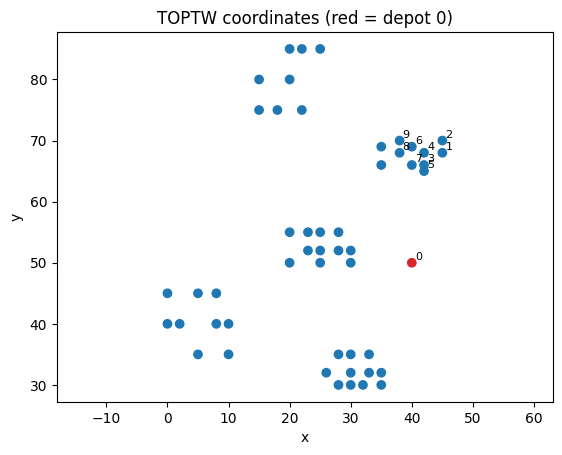

Created:
 - ../benchmarks//benchmarks_cap_json/50_rc106_cap.json
 - ../benchmarks//benchmarks_cap_json/c106_cap.json
 - ../benchmarks//benchmarks_cap_json/50_r106_cap.json
 - ../benchmarks//benchmarks_cap_json/r105_cap.json
 - ../benchmarks//benchmarks_cap_json/rc105_cap.json
 - ../benchmarks//benchmarks_cap_json/50_c101_cap.json
 - ../benchmarks//benchmarks_cap_json/c103_cap.json
 - ../benchmarks//benchmarks_cap_json/c107_cap.json
 - ../benchmarks//benchmarks_cap_json/50_r104_cap.json
 - ../benchmarks//benchmarks_cap_json/r106_cap.json
 - ../benchmarks//benchmarks_cap_json/50_r108_cap.json
 - ../benchmarks//benchmarks_cap_json/50_r107_cap.json
 - ../benchmarks//benchmarks_cap_json/50_r112_cap.json
 - ../benchmarks//benchmarks_cap_json/50_c109_cap.json
 - ../benchmarks//benchmarks_cap_json/50_c106_cap.json
 - ../benchmarks//benchmarks_cap_json/50_c105_cap.json
 - ../benchmarks//benchmarks_cap_json/r112_cap.json
 - ../benchmarks//benchmarks_cap_json/r102_cap.json
 - ../benchmarks//bench

In [14]:
from dataclasses import dataclass
from typing import List, Optional, Tuple
import math, re, pathlib

@dataclass
class TOPTWNode:
    i: int
    x: float
    y: float
    service: float   # d
    profit: float    # S
    tw_open: float   # O
    tw_close: float  # C
    f: int           # not relevant (kept for completeness)
    a: int           # 'a' value; the length of aux_list
    aux_list: List[int]  # variable-length list after 'a'

@dataclass
class TOPTWInstance:
    path: str
    k: int
    v: int
    N: int
    t: int
    D: Optional[float]
    Q: Optional[float]
    Tmax: float                # equals depot.tw_close
    nodes: List[TOPTWNode]     # length N+1 (0..N)

def _floor_to_decimals(x: float, decimals: int) -> float:
    if decimals is None:
        return float(x)
    f = 10 ** decimals
    return math.floor(x * f) / f

def _auto_rounding_decimals_from_name(path: str) -> int:
    # c101, r201, rc2xx -> Solomon (1 decimal); else Cordeau (2 decimals)
    name = pathlib.Path(path).name.lower()
    if re.search(r'(?:^|_)((c|r|rc)\d+)', name):
        return 1
    return 2

def build_distance_time_matrices(inst: TOPTWInstance,
                                 speed: float = 1.0,
                                 rounding: str = "auto"  # "auto"|"solomon"|"cordeau"|"none"
                                 ) -> Tuple[List[List[float]], List[List[float]]]:
    pts = [(n.x, n.y) for n in inst.nodes]
    n = len(pts)
    if rounding == "auto":
        dec = _auto_rounding_decimals_from_name(inst.path)
    elif rounding == "solomon":
        dec = 1
    elif rounding == "cordeau":
        dec = 2
    else:
        dec = None

    def euclid(a, b): return math.hypot(a[0]-b[0], a[1]-b[1])

    dist = [[0.0]*n for _ in range(n)]
    tmat = [[0.0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i == j:
                d = 0.0
            else:
                d = euclid(pts[i], pts[j])
                d = _floor_to_decimals(d, dec)
            dist[i][j] = d
            tmat[i][j] = d / speed if speed > 0 else d
    return dist, tmat

def parse_toptw_instance(path: str) -> TOPTWInstance:
    path = str(path)
    with open(path, "r", encoding="utf-8") as f:
        raw_lines = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("*")]

    # Header 1: k v N t
    k, v, N, t = map(int, raw_lines[0].split())

    # Header 2: "D Q" or just "Q"
    hdr2 = raw_lines[1].split()
    if len(hdr2) >= 2:
        D = float(hdr2[0])
        Q = float(hdr2[1])
    elif len(hdr2) == 1:
        D = None
        Q = float(hdr2[0])
    else:
        D = None
        Q = None

    # Node lines: expect N+1, including depot 0
    nodes: List[TOPTWNode] = []
    expected = N + 1
    lines = raw_lines[2:2+expected]

    for ln in lines:
        toks = ln.split()
        # Fixed part
        i = int(toks[0])
        x = float(toks[1]); y = float(toks[2])
        d = float(toks[3])     # service
        S = float(toks[4])     # profit
        f = int(float(toks[5]))
        a = int(float(toks[6]))

        pos_after_list = 7 + a
        if len(toks) >= pos_after_list + 2:
            aux = [int(float(t)) for t in toks[7:7+a]] if a > 0 else []
            O = float(toks[pos_after_list])
            C = float(toks[pos_after_list + 1])
        else:
            # Fallback: treat last two as O,C; anything in between as aux
            O = float(toks[-2]); C = float(toks[-1])
            aux = [int(float(t)) for t in toks[7:-2]] if len(toks) > 9 else []

        nodes.append(TOPTWNode(
            i=i, x=x, y=y, service=d, profit=S,
            tw_open=O, tw_close=C, f=f, a=a, aux_list=aux
        ))

    Tmax = nodes[0].tw_close  # per format
    return TOPTWInstance(path=path, k=k, v=v, N=N, t=t, D=D, Q=Q, Tmax=Tmax, nodes=nodes)

import os, pandas as pd

DEFAULT_PATH = parameters["benchmark_file"]
PATH_TO_FILE = DEFAULT_PATH if os.path.exists(DEFAULT_PATH) else ""

if PATH_TO_FILE:
    inst = parse_toptw_instance(PATH_TO_FILE)
    print(f"Loaded: {inst.path}")
    print(f"k={inst.k}, v={inst.v}, N={inst.N}, t={inst.t}, D={inst.D}, Q={inst.Q}, Tmax={inst.Tmax}")
    df_nodes = pd.DataFrame([{
        "i":n.i,"x":n.x,"y":n.y,"service":n.service,"profit":n.profit,
        "O":n.tw_open,"C":n.tw_close,"a":n.a,"aux_len":len(n.aux_list)
    } for n in inst.nodes])
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("TOPTW nodes (preview)", df_nodes.head(12))
    except Exception:
        display(df_nodes.head(12))
else:
    print("Please set PATH_TO_FILE to the path of your Righini & Salani TOPTW .txt file.")

import matplotlib.pyplot as plt
import numpy as np

if PATH_TO_FILE:
    dist, tmat = build_distance_time_matrices(inst, rounding="auto")
    print("Distance matrix shape:", (len(dist), len(dist)))
    print("Example distances from depot (node 0) to first 5 nodes:", dist[0][:6])

    xs = [n.x for n in inst.nodes]
    ys = [n.y for n in inst.nodes]
    colors = ["tab:red" if n.i==0 else "tab:blue" for n in inst.nodes]
    plt.figure()
    plt.scatter(xs, ys, c=colors)
    for n in inst.nodes[:10]:  # annotate a few
        plt.text(n.x+0.5, n.y+0.5, str(n.i), fontsize=8)
    plt.title("TOPTW coordinates (red = depot 0)")
    plt.xlabel("x"); plt.ylabel("y")
    plt.axis("equal")
    plt.show()

from dataclasses import dataclass
from typing import List, Optional

@dataclass
class TOPTWNode:
    i: int
    x: float
    y: float
    service: float    # service duration
    profit: float     # profit / score
    tw_open: float    # earliest service time
    tw_close: float   # latest service time
    f: int            # extra field from original format
    a: int            # length of aux_list in original file
    aux_list: List[int]
    demand: int = 0   # NEW: demand of this node (0 for depot)

@dataclass
class TOPTWInstance:
    path: str
    k: int            # number of vehicles / routes allowed
    v: int            # carried over from source format
    N: int            # number of customers (excl. depot)
    t: int            # carried over from source format
    D: Optional[float]
    Q: Optional[float]   # vehicle capacity we'll assign
    Tmax: float          # usually depot.tw_close in source data
    nodes: List[TOPTWNode]

import math
import numpy as np
from typing import Tuple, List

def generate_demands(
    inst: TOPTWInstance,
    mode: str = "independent",
    rng: np.random.Generator | None = None,
    demand_range: Tuple[int, int] = (1,10)
) -> List[int]:
    """
    Create integer demands for each node of a TOPTWInstance.
    Index 0 (depot) always gets demand 0.

    mode:
      - 'independent': uniform integer in [lo,hi]
      - 'correlate_profit': scale profit to [lo,hi]
      - 'depot_distance': scale euclidean distance-from-depot to [lo,hi]
    """
    lo, hi = demand_range
    n_total = inst.N + 1

    if rng is None:
        rng = np.random.default_rng()

    demands = [0]*n_total  # depot = 0

    if inst.N == 0:
        return demands

    if mode == "independent":
        demands[1:] = rng.integers(lo, hi+1, size=inst.N).tolist()

    elif mode == "correlate_profit":
        profits = [n.profit for n in inst.nodes]
        min_p = min(profits[1:])
        max_p = max(profits[1:])
        if max_p == min_p:
            demands[1:] = [ (lo+hi)//2 ]*inst.N
        else:
            for idx in range(1,n_total):
                p = inst.nodes[idx].profit
                scaled = lo + (p-min_p)*(hi-lo)/(max_p-min_p)
                d_int = int(round(scaled))
                d_int = max(lo, min(hi, d_int))
                demands[idx] = d_int

    elif mode == "depot_distance":
        x0,y0 = inst.nodes[0].x, inst.nodes[0].y
        dists = [0.0]*n_total
        for idx in range(1,n_total):
            n = inst.nodes[idx]
            dists[idx] = math.hypot(n.x-x0, n.y-y0)
        min_d = min(dists[1:])
        max_d = max(dists[1:])
        if max_d == min_d:
            demands[1:] = [ (lo+hi)//2 ]*inst.N
        else:
            for idx in range(1,n_total):
                dd = dists[idx]
                scaled = lo + (dd-min_d)*(hi-lo)/(max_d-min_d)
                d_int = int(round(scaled))
                d_int = max(lo, min(hi, d_int))
                demands[idx] = d_int
    else:
        raise ValueError(f"Unknown mode: {mode}")

    return demands

def choose_capacity(demands: List[int], K: int, Q_ratio: float = 0.25) -> int:
    """Pick per-vehicle capacity Q.

    We try to enforce that K*Q ~= Q_ratio * total_demand, so
    capacity becomes binding. We also ensure that Q is at least
    each single customer's demand so serving one node is feasible.
    """
    total_demand = sum(demands[1:])  # ignore depot
    if total_demand <= 0:
        return 0

    target_combined = Q_ratio * total_demand
    if target_combined < 1:
        target_combined = 1

    if K > 0:
        Q = math.floor(target_combined / K)
    else:
        Q = math.floor(target_combined)

    if Q < 1:
        Q = 1

    max_single = max(demands[1:]) if len(demands) > 1 else 0
    if Q < max_single:
        Q = max_single

    return int(Q)

import os, json, glob
import pathlib

def convert_to_capacitated_json(
    inst_paths,
    out_dir: str = "benchmarks_cap_json",
    K: int | None = None,
    demand_mode: str = "independent",
    demand_range: tuple[int,int] = (1,10),
    Q_ratio: float = 0.25,
    seed: int | None = None,
):
    """
    Build capacitated variants (with random demands + capacity Q) and
    save them as JSON. Returns list of written file paths.

    inst_paths can be:
      - a directory of .txt files,
      - a single .txt path,
      - or a list of paths.
    """
    os.makedirs(out_dir, exist_ok=True)

    # collect input files
    if isinstance(inst_paths, str):
        if os.path.isdir(inst_paths):
            files = glob.glob(os.path.join(inst_paths, "**", "*.txt"), recursive=True)
        else:
            files = [inst_paths]
    else:
        files = list(inst_paths)

    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()

    outfiles = []
    for file_path in files:
        # parse original benchmark into TOPTWInstance (demands currently 0)
        inst = parse_toptw_instance(file_path)

        num_vehicles = K if K is not None else (inst.k if inst.k else 1)

        demands = generate_demands(
            inst,
            mode=demand_mode,
            rng=rng,
            demand_range=demand_range,
        )

        cap_Q = choose_capacity(demands, K=num_vehicles, Q_ratio=Q_ratio)

        data = {
            "name": os.path.splitext(os.path.basename(file_path))[0],
            "k": num_vehicles,
            "v": inst.v,
            "N": inst.N,
            "t": inst.t,
            "D": inst.D,
            "Q": cap_Q,
            "Tmax": inst.Tmax,
            "nodes": []
        }

        for node, d in zip(inst.nodes, demands):
            data["nodes"].append({
                "i": node.i,
                "x": node.x,
                "y": node.y,
                "service": node.service,
                "profit": node.profit,
                "tw_open": node.tw_open,
                "tw_close": node.tw_close,
                "f": node.f,
                "a": node.a,
                "aux_list": node.aux_list,
                "demand": int(d)
            })

        out_name = data["name"] + "_cap.json"
        out_path_single = os.path.join(out_dir, out_name)
        with open(out_path_single, "w") as jf:
            json.dump(data, jf, indent=2)

        outfiles.append(out_path_single)

    return outfiles


def load_capacitated_instance(json_path: str) -> TOPTWInstance:
    """Load a JSON file created by convert_to_capacitated_json back into TOPTWInstance."""
    with open(json_path, "r") as f:
        data = json.load(f)

    nodes: List[TOPTWNode] = []
    for nd in data["nodes"]:
        nodes.append(
            TOPTWNode(
                i=nd["i"],
                x=nd["x"],
                y=nd["y"],
                service=nd["service"],
                profit=nd["profit"],
                tw_open=nd["tw_open"],
                tw_close=nd["tw_close"],
                f=nd["f"],
                a=nd["a"],
                aux_list=nd["aux_list"],
                demand=nd.get("demand",0),
            )
        )

    inst = TOPTWInstance(
        path=data.get("name", json_path),
        k=data["k"],
        v=data["v"],
        N=data["N"],
        t=data["t"],
        D=data["D"],
        Q=data["Q"],
        Tmax=data["Tmax"],
        nodes=nodes,
    )
    return inst

SRC_DIR = parameters["benchmark_directory"]          # folder containing original .txt instances
OUT_DIR_JSON = parameters["benchmark_directory"] + "/benchmarks_cap_json"

try:
    created = convert_to_capacitated_json(
        inst_paths=SRC_DIR,
        out_dir=OUT_DIR_JSON,
        K=hyperparameters["K"],                           # force 3 vehicles for everyone
        demand_mode="independent",     # random uniform demands
        demand_range=(1,10),
        Q_ratio=0.25,                  # fleet can carry ~25% of total demand
        seed=parameters["seed"],
    )
    print("Created:") 
    for p in created:
        print(" -", p)

    if created:
        demo_file = created[0]
        inst_cap = load_capacitated_instance(demo_file)
        print("\nLoaded:", inst_cap.path)
        print("Vehicles k:", inst_cap.k)
        print("Vehicle capacity Q:", inst_cap.Q)
        print("Tmax:", inst_cap.Tmax)
        print("#nodes (incl. depot):", len(inst_cap.nodes))
        print("Demands:", [n.demand for n in inst_cap.nodes])
except NameError as e:
    print("You still need to run the original parser cell so parse_toptw_instance is defined.") 
    print(e)
except FileNotFoundError as e:
    print("Make sure SRC_DIR points to your benchmarks folder with .txt files.")
    print(e)

